Step 1 : Importing the required libraries

In [1]:
#import required libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Step 2 : Routing the path of the dataset

In [3]:
from pathlib import Path

# use current working directory
base_dir = Path.cwd()
data_dir = base_dir / "Dataset"

print(f"Data directory: {data_dir}")

categories = ["M5_bolt", "M6_bolt", "M8_bolt","M12_bolt","M5_nut","M6_nut","M8_nut","M12_nut"]
img_size = 224

Data directory: C:\Users\vigne\Desktop\CW2_ML_PDE4433\Dataset


Step 3 : Loading the dataset and preprocessing

In [4]:
def load_data():
    data = []
    labels = []
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)  
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)

                gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
                blurred = cv2.GaussianBlur(gray, (19, 19), 5)
                _, thresh = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)
                edges = cv2.Canny(thresh, 100, 200)

                kernel = np.ones((5, 5), np.uint8)
                dilated = cv2.dilate(edges, kernel, iterations=2)
                eroded = cv2.erode(dilated, kernel, iterations=1)

                contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Process only if we have at least one valid contour
                for cnt in contours:
                    area = cv2.contourArea(cnt)
                    if area > 100:  # Filter small areas
                        x, y, w, h = cv2.boundingRect(cnt)
                        cropped = img_array[y:y+h, x:x+w]

                        output_size = 244
                        white_bg = np.ones((output_size, output_size, 3), dtype=np.uint8) * 255

                        # Ensure cropped size fits
                        ch, cw = cropped.shape[:2]
                        if ch <= output_size and cw <= output_size:
                            y_offset = (output_size - ch) // 2
                            x_offset = (output_size - cw) // 2

                            white_bg[y_offset:y_offset+ch, x_offset:x_offset+cw] = cropped

                            # Resize to final model input size
                            final_img = cv2.resize(white_bg, (img_size, img_size))

                            data.append(final_img)
                            labels.append(label)

                        break
            except Exception as e:
                print(f"Error loading image: {e}")
    return np.array(data), np.array(labels)

Step 4 : Loading the data and reshaping to prepare for training process

In [5]:
X, y = load_data()
X = X.reshape(-1, img_size, img_size, 3) / 255.0  
y = tf.keras.utils.to_categorical(y, num_classes=len(categories)) 
print(X.shape,y.shape)

(264, 224, 224, 3) (264, 8)


Step 5 : Spliting the data for training and testing

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 6 : MobileNetV2 Pre-trained Model

In [11]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False 

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

Step 7 : Compiling the model

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Step 8 : Training the model

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.3651 - loss: 11.5020 - val_accuracy: 0.7358 - val_loss: 2.5865
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7495 - loss: 2.7969 - val_accuracy: 0.8679 - val_loss: 0.6902
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8240 - loss: 1.5460 - val_accuracy: 0.9623 - val_loss: 0.1809
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8893 - loss: 0.5750 - val_accuracy: 0.9623 - val_loss: 0.3815
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.8786 - loss: 0.5772 - val_accuracy: 0.9623 - val_loss: 0.4221
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8547 - loss: 0.5132 - val_accuracy: 0.9811 - val_loss: 0.0562
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8920 - loss: 0.3215 - val_accuracy: 0.9811 - val_loss: 0.1039
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9060 - loss: 0.2561 - val_acc

Step 9 : Evaluating the accuracy of the model

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9874 - loss: 0.0312
Test Accuracy: 98.11%


Step 10 : Model Summary

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,345,946 (100.50 MB)

 Trainable params: 8,029,320 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 16,058,642 (61.26 MB)

Step 11 : Model Performance graph

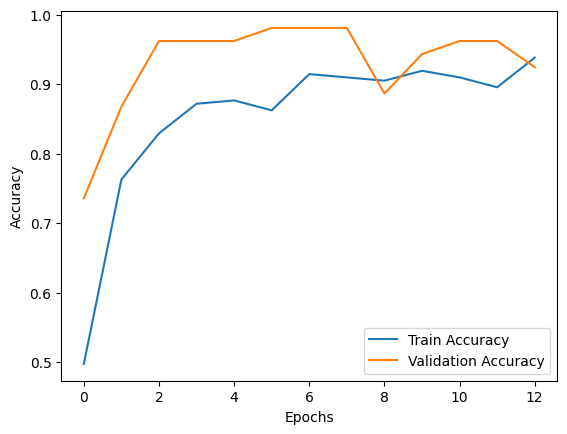

In [16]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Step 12 : Save the Model

In [17]:
model.save("bolt_nut_classifier_using_Mobilenet2.keras",include_optimizer=False)

Step 13 : Function for ploting the image

In [1]:
def show_image(img, title="Image", cmap=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

Step 14 : Testing the Model with Images which are not involved in training

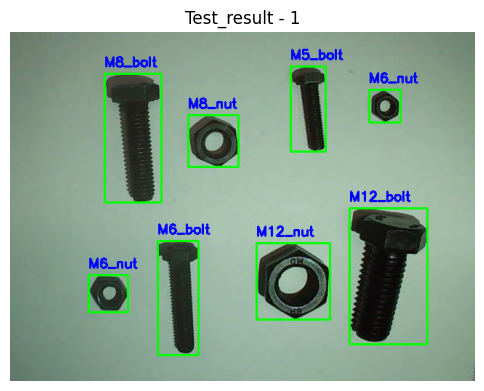

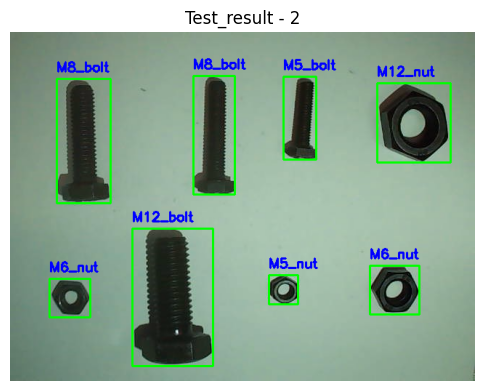

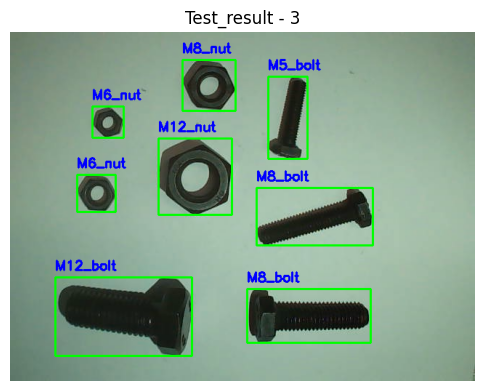

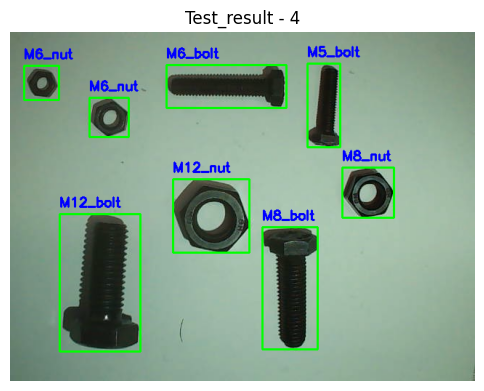

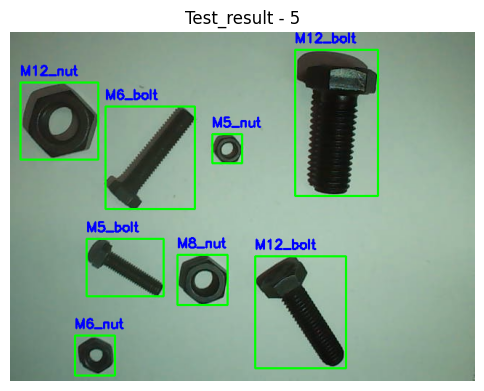

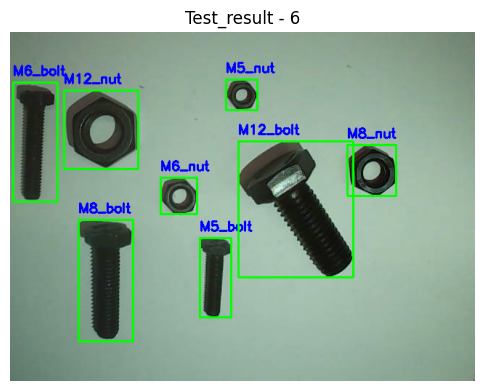

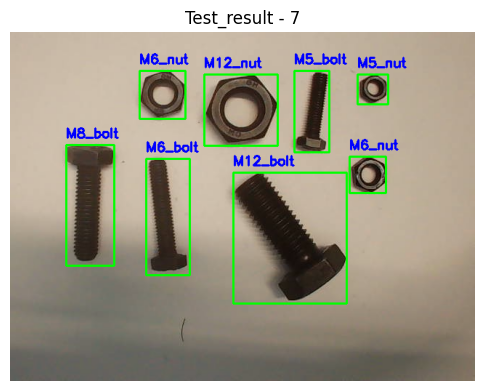

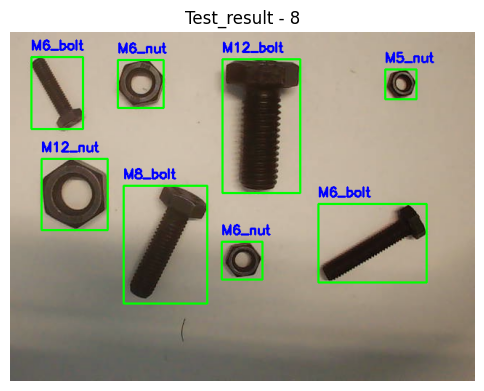

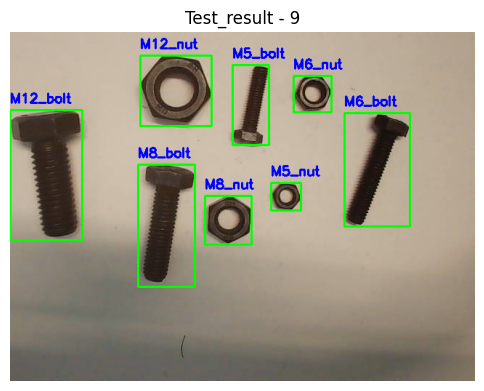

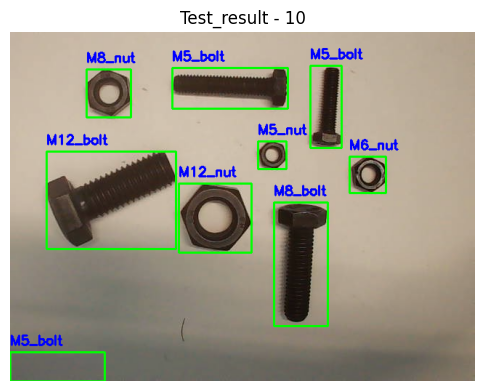

In [5]:
#Testing the model with the test images

import cv2
import numpy as np
import tensorflow as tf
import time
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load trained model
model = tf.keras.models.load_model("bolt_nut_classifier_using_Mobilenet2.keras")
img_size=224

# Define categories
categories = ["M5_bolt", "M6_bolt", "M8_bolt", "M12_bolt", "M5_nut", "M6_nut", "M8_nut", "M12_nut"]

# use current working directory
base_dir = Path.cwd()
Test_dir = base_dir / "Dataset" / "Test"

for test in range(10):
    test+=1
    value=str(test)
    image = Test_dir / f"{value}.jpg" 
    test_image = cv2.imread(image)

    gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (19, 19), 5)
    _, thresh = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(thresh, 100, 200)

    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=1)

    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Process only if we have at least one valid contour
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 100:  # Optional: Filter small areas
            x, y, w, h = cv2.boundingRect(cnt)
            cropped = test_image[y:y+h, x:x+w]

            output_size = 244
            white_bg = np.ones((output_size, output_size, 3), dtype=np.uint8) * 255

            # Ensure cropped size fits
            ch, cw = cropped.shape[:2]
            if ch <= output_size and cw <= output_size:
                y_offset = (output_size - ch) // 2
                x_offset = (output_size - cw) // 2

                white_bg[y_offset:y_offset+ch, x_offset:x_offset+cw] = cropped

                # Resize to final model input size
                final_img = cv2.resize(white_bg, (img_size, img_size))

                # Preprocess the image
                img_processed = preprocess_input(final_img.astype(np.float32))
                img_array = np.expand_dims(img_processed, axis=0)
                
                predictions = model.predict(img_array, verbose=0)
                class_id = np.argmax(predictions)
                confidence = np.max(predictions)

                # Draw rectangle and label
                label = f"{categories[class_id]}"#" ({confidence * 100:.2f}%)"
                cv2.rectangle(test_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(test_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    show_image(test_image,"Test_result - "+str(test),cmap="grey")

Step 15 : Live Detection

In [6]:
#live camera detection

import cv2
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

img_size=224

# Load trained model
model = tf.keras.models.load_model("bolt_nut_classifier.keras")

# Define categories
categories = ["M5_bolt", "M6_bolt", "M8_bolt", "M12_bolt", "M5_nut", "M6_nut", "M8_nut", "M12_nut"]

# Open Webcam
cap = cv2.VideoCapture(0)

# Set frame width and height
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

while True:
    ret, frame = cap.read()
    if not ret:
        break

        
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (19, 19), 5)
    _, thresh = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(thresh, 100, 200)

    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=1)

    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Process only if we have at least one valid contour
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 100:  # Optional: Filter small areas
            x, y, w, h = cv2.boundingRect(cnt)
            cropped = frame[y:y+h, x:x+w]

            output_size = 244
            white_bg = np.ones((output_size, output_size, 3), dtype=np.uint8) * 255

            # Ensure cropped size fits
            ch, cw = cropped.shape[:2]
            if ch <= output_size and cw <= output_size:
                y_offset = (output_size - ch) // 2
                x_offset = (output_size - cw) // 2

                white_bg[y_offset:y_offset+ch, x_offset:x_offset+cw] = cropped

                # Resize to final model input size
                final_img = cv2.resize(white_bg, (img_size, img_size))

                # Preprocess the image
                img_processed = preprocess_input(final_img.astype(np.float32))
                img_array = np.expand_dims(img_processed, axis=0)
                
                predictions = model.predict(img_array, verbose=0)
                class_id = np.argmax(predictions)
                confidence = np.max(predictions)

                # Draw rectangle and label
                label = f"{categories[class_id]}"#" ({confidence * 100:.2f}%)"
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Show video feed
    cv2.imshow("Live Detection using MobileNetv2", frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()